<a href="https://colab.research.google.com/github/jademdias/ProgISD20202/blob/master/Jade/Aula10/AtivContext10/NotebookProjetoEEGEMG_Jade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
#from numpy import genfromtxt
import matplotlib.pyplot as plt
import pandas as pd
from math import ceil, floor
from scipy.signal import decimate
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [79]:
!pwd

/gdrive


In [44]:
#!unzip "/gdrive/Shared drives/ProjetoMarcela/EEG/Carol-20200907T111856Z-001.zip"

Funções

In [81]:
def remover_faltantes(dados):
  resultado = dados.dropna()
  return resultado

In [82]:
def calcular_frequencia(tempo):
  delta_tempo = tempo[3] - tempo[2]
  frequencia = int(1 / delta_tempo)
  return frequencia

In [83]:
def q_decimate(freq1, freq2):
  if(freq1 > freq2):  
    q_decimate = ceil(freq1/freq2)
  else: 
    q_decimate = ceil(freq2/freq1)
  return q_decimate

In [84]:
def normalizar_dados(dados):
  resultado = dados**2/(dados.max())**2
  #scaler = StandardScaler()
  #scaler = MinMaxScaler()
  #scaler.fit(dados)
  #resultado = scaler.fit_transform(dados.reshape(-1, 1))
  #resultado = scaler.transform(dados)
  return resultado

In [85]:
def calcular_decimate(dados, q):
  resultado = decimate(dados, q)
  return resultado

In [86]:
def gerar_trials(dados, duracao, frequencia_atual):
  duracao = int(duracao)
  frequencia_atual = floor(frequencia_atual) 
  condicao = int(duracao * frequencia_atual)
  
  while(int(len(dados)) > condicao):
    dados = np.delete(dados, -1)

  trials = np.reshape(dados, (duracao, frequencia_atual))
  return trials

In [87]:
def adicionar_points(dados, frequencia_atual, frequencia_desejada):
  qd = frequencia_desejada - frequencia_atual
  quantidade_arrays = len(dados)
  dados = dados.tolist()
  lista_aux = []
  for i in range(quantidade_arrays):
    indice = 0
    dado = dados[i]
    constante = int(len(dado)/qd)
    for j in range(qd):
      calculo = (dado[indice] + dado[indice + 1])/2
      dado.insert(indice, calculo)
      indice = indice + constante
    lista_aux.append(dado)

  nova_lista = []

  for i in range(quantidade_arrays):
    nova_lista = nova_lista + lista_aux[i]

  return nova_lista 

In [88]:
def calcular_correlacao(dados_eeg, dados_emg):
  tamanho_eeg = len(dados_eeg)
  tamanho_emg = len(dados_emg)
  limite_inicial = 0
  limite_final = tamanho_eeg
  registro_eqm = []
  print("Calculando...")
  while True:

    eqm = np.corrcoef(dados_eeg, dados_emg[limite_inicial:limite_final])

    registro_eqm.append(eqm[0,1])

    limite_inicial = limite_inicial + 1
    limite_final = limite_final + 1
    
    if limite_final == tamanho_emg:
      print("Calculo realizado!")
      break
  
  return registro_eqm

In [89]:
def pre_processamento_sinal(dados):
  results = remover_faltantes(dados)
  results = normalizar_dados(results)
  return results

In [90]:
def ajustar_frequencia(dados, tempo_eeg, tempo_emg):
  tempo_eeg = remover_faltantes(tempo_eeg)
  tempo_emg = remover_faltantes(tempo_emg)
  frequencia_eeg = calcular_frequencia(tempo_eeg)
  frequencia_emg = calcular_frequencia(tempo_emg)
  qd = q_decimate(frequencia_emg, frequencia_eeg)
  results = pre_processamento_sinal(dados)
  results = calcular_decimate(results, qd)

  ind_final = len(tempo_eeg)
  indice_final = ind_final - 1

  duracao_total = floor(tempo_eeg[indice_final] - tempo_eeg[0]) - 1

  results = gerar_trials(results, duracao_total, int(frequencia_eeg/qd))
  results = adicionar_points(results, int(frequencia_eeg/qd), frequencia_emg)
  return results

In [91]:
def encontrar_inicio_sincrono(dadoEMG, dadoEEG, a, b, c, d):
  P_EMG_TRIG = dadoEMG.iloc[2:,29]
  P_EEG_TRIG = dadoEEG.iloc[2:,19]
  P_EMG_TIME = dadoEMG.iloc[:,28]
  P_EEG_TIME = dadoEEG.iloc[:,0]

  P_EMG_TIME = remover_faltantes(P_EMG_TIME)
  P_EEG_TIME = remover_faltantes(P_EEG_TIME)

  P_EEG_TRIG = ajustar_frequencia(P_EEG_TRIG, P_EEG_TIME, P_EMG_TIME)

  correlacao = calcular_correlacao(P_EMG_TRIG[a:b], P_EEG_TRIG[c:d])

  inicio_sincrono = correlacao.index(max(correlacao))
  
  print("Inicio Síncrono: " + str(inicio_sincrono))
  print("Correlação: " + str(max(correlacao)))

  emg_sincrono = P_EMG_TRIG

  eeg_sincrono = P_EEG_TRIG[inicio_sincrono:]

  return inicio_sincrono

In [92]:
P1_T1_EMG = pd.read_csv('Shared drives/ProjetoMarcela/Novas coletas marco 2020/Dados EMG/Coleta MARCELA/Livia/Coleta 3.csv', delimiter=',', header=116)
P1_T1_EEG = pd.read_csv('Shared drives/ProjetoMarcela/Novas coletas marco 2020/Dados EEG/Livia/livia-[2020.03.04-16.20.57].csv', delimiter=',')

In [93]:
#16canais
#canais_eeg= P1_T1_EEG.iloc[2:, 2:18]

eeg_sincrono = encontrar_inicio_sincrono(P1_T1_EMG, P1_T1_EEG, 0, 3000, 0, len(P1_T1_EEG))

Calculando...
Calculo realizado!
Inicio Síncrono: 817
Correlação: 0.952060675803017


In [94]:
eeg_sincrono

817

Segunda parte: corte das colisões


In [95]:
P1_T1_EMG_FCRX = P1_T1_EMG.iloc[2:,29]
P1_T1_EEG_FCRX = P1_T1_EEG.iloc[2:,19]
colision_EEG = P1_T1_EEG.iloc[2:,20]
canais = P1_T1_EEG.iloc[2:, 2: 18]

In [96]:
tempo_emg = P1_T1_EMG.iloc[2:,28]
tempo_eeg = P1_T1_EEG.iloc[2:,0]
#Remover NaN
tempo_emg = remover_faltantes(tempo_emg)
tempo_eeg = remover_faltantes(tempo_eeg)

P1_T1_EMG_FCRX = remover_faltantes(P1_T1_EMG_FCRX)
P1_T1_EEG_FCRX = remover_faltantes(P1_T1_EEG_FCRX)


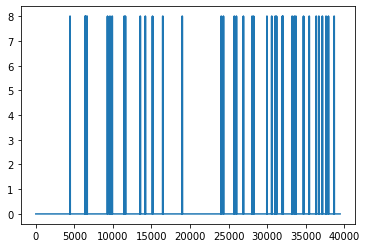

In [97]:
#Plot da colisão
plt.plot(colision_EEG)
colisionlist=colision_EEG.to_numpy()
timelist=tempo_eeg.to_numpy()

In [98]:
def remover_colisoes_sucessivas(index_collision):
  #c = [index_colision[0]]
  c=[]
  for i in range(len(index_collision)):
    #if (index_collision[i-1] != index_collision[i]-1):
    if (index_collision[i] - index_collision[i-1]> 512):
      c.append(index_collision[i])  
  return c

#lista = [1, 2, 3, 6, 8, 12, 13, 14, 15, 20, 21, 23, 24 ,29]

#novo = remover_colisoes_sucessivas(lista)
#print (novo)

In [99]:
index_colision=[]
for i in range(len(colisionlist)):
 if(colisionlist[i] == 8.0):
   index_colision.append(i)
print("Indices de colisões: ", index_colision)
idx_collision= remover_colisoes_sucessivas(index_colision)
print("Indices com colisões sucessivas removidas (intervalo de 1s): ",idx_collision)
print("Quantidade de colisões: ", len(idx_collision))
tempo_colisao=[]
for i in idx_collision:
  tempo_colisao.append(tempo_eeg[i])
print("Tempo correspondente a colisão: ", tempo_colisao)

Indices de colisões:  [4410, 4411, 4412, 4413, 4414, 4415, 4416, 4417, 4461, 4462, 4463, 6354, 6355, 6356, 6357, 6358, 6359, 6360, 6361, 6405, 6406, 6407, 6453, 6454, 6455, 6456, 6457, 6458, 6459, 6460, 6504, 6505, 6616, 6617, 6618, 6619, 6620, 6621, 6622, 6623, 6667, 6668, 6669, 9271, 9272, 9273, 9274, 9275, 9276, 9277, 9278, 9322, 9323, 9587, 9588, 9589, 9590, 9591, 9592, 9593, 9594, 9638, 9639, 9640, 9872, 9873, 9874, 9875, 9876, 9877, 9878, 9922, 9923, 9924, 11433, 11434, 11435, 11436, 11437, 11438, 11439, 11440, 11484, 11485, 11486, 11586, 11587, 11588, 11589, 11590, 11591, 11592, 11593, 11637, 11638, 13509, 13510, 13511, 13512, 13513, 13514, 13515, 13559, 13560, 13561, 14164, 14165, 14166, 14167, 14168, 14169, 14170, 14171, 14215, 14216, 15103, 15104, 15105, 15106, 15107, 15108, 15109, 15110, 15154, 15155, 16436, 16437, 16438, 16439, 16440, 16441, 16442, 16443, 16487, 16488, 18948, 18949, 18950, 18951, 18952, 18953, 18954, 18955, 18999, 19000, 24005, 24006, 24007, 24008, 24009, 2

In [100]:
  #Calcula a frequência (inverso do período 1/T)
  frequencia_eeg = calcular_frequencia(tempo_eeg)
  frequencia_emg = calcular_frequencia(tempo_emg)
  frequencia_eeg
  #frequencia_emg

512

In [101]:
#Razão entre as frequências
qd = q_decimate(frequencia_emg, frequencia_eeg)
qd

4

In [102]:
#results = pre_processamento_sinal(dados)
results = calcular_decimate(P1_T1_EEG_FCRX, qd)
rt = calcular_decimate(tempo_eeg, qd)

results = normalizar_dados(results)
#rt= normalizar_dados(rt)

In [103]:
results

array([1.08519235, 1.08413457, 1.0837862 , ..., 1.24116111, 1.24285242,
       1.24484278])

In [104]:
ind_final = len(tempo_eeg)
indice_final = ind_final - 1

duracao_total = floor(tempo_eeg[indice_final] - tempo_eeg[2]) - 1

In [105]:
results = gerar_trials(results, duracao_total, int(frequencia_eeg/qd))
rt= gerar_trials(rt, duracao_total, int(frequencia_eeg/qd))

In [106]:
results = adicionar_points(results, int(frequencia_eeg/qd), frequencia_emg)

rt = adicionar_points(rt, int(frequencia_eeg/qd), frequencia_emg)


In [107]:
print(len(rt), len(results))

11248 11248


In [108]:
registro_corr = calcular_correlacao(P1_T1_EMG_FCRX[:3000], results)

Calculando...
Calculo realizado!


In [109]:
inicio_sincrono = registro_corr.index(max(registro_corr))
print("Inicio Síncrono: " + str(inicio_sincrono))
print(max(registro_corr))

Inicio Síncrono: 817
0.9520606758021437


In [110]:
#Para cada canal
canais_sinc=[]
for i in range(2,18):
  canalres = calcular_decimate(P1_T1_EEG.iloc[2:, i], qd)
  canalres = gerar_trials(canalres, duracao_total, int(frequencia_eeg/qd))
  canalres = adicionar_points(canalres, int(frequencia_eeg/qd), frequencia_emg)
  canalres = canalres[inicio_sincrono:]
  canais_sinc.append(canalres)


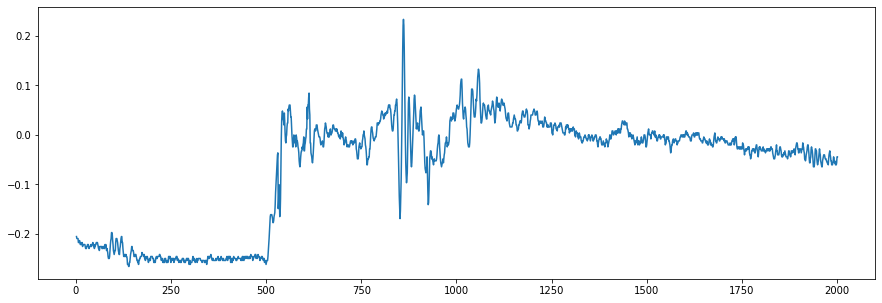

In [111]:
plt.figure(figsize=[15, 5])
plt.plot(P1_T1_EMG_FCRX[0:2000])

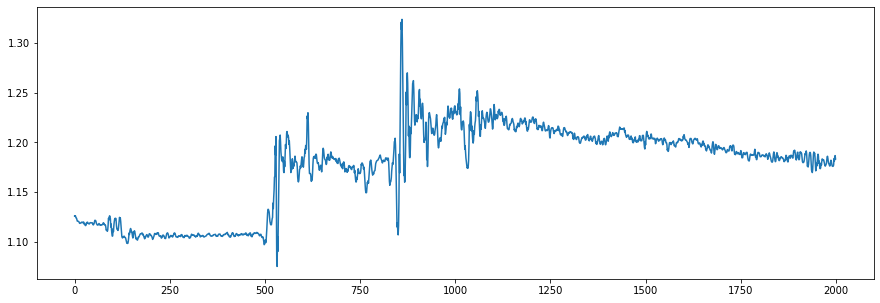

In [112]:
plt.figure(figsize=[15, 5])
eeg_sinc=results[inicio_sincrono:]
rt_sinc= rt[inicio_sincrono:]
emg_sinc= P1_T1_EMG_FCRX[0:10431].to_numpy()
plt.plot(eeg_sinc[0:2000])
#plt.plot(eeg_sinc)

In [113]:
print(len(eeg_sinc), len(rt_sinc), len(emg_sinc))


10431 10431 10431


In [114]:
def tempo_aproximado(teste, value):
  differences=[]
  tempoaprox=0
  for a in teste:
    dif= (a - value)**2 
    differences.append(dif)
  dif_min= min(differences)
  for i in range(len(differences)):
    if(differences[i] == dif_min):
      tempo_aprox = teste[i]
      idx= i
  print("Tempo aproximado: ", tempo_aprox)
  return idx

idx_tempo_aprox=[]
for a in tempo_colisao:
  idx_tempo_aprox.append(tempo_aproximado(rt_sinc, a))
#idx_tempo_aprox= tempo_aproximado(rt, tempo_colisao[0])
print("Tempo original: ", tempo_colisao)
print("Indice tempo aproximado: ", idx_tempo_aprox)
print("Indice tempo original: ", idx_collision)

Tempo aproximado:  12.410975180555454
Tempo aproximado:  18.106740081356612
Tempo aproximado:  22.331259946867142
Tempo aproximado:  26.38587224915349
Tempo aproximado:  27.667902043812333
Tempo aproximado:  29.498269883064594
Tempo aproximado:  32.10094482776653
Tempo aproximado:  37.00895648113183
Tempo aproximado:  46.882902821166965
Tempo aproximado:  50.18837723142194
Tempo aproximado:  52.49757547587603
Tempo aproximado:  54.71409686808566
Tempo aproximado:  58.46750939894223
Tempo aproximado:  59.68003155422861
Tempo aproximado:  62.37538335137052
Tempo aproximado:  64.84676608821555
Tempo aproximado:  67.72747159055233
Tempo aproximado:  69.15623973508127
Tempo aproximado:  70.92868454156951
Tempo aproximado:  75.12617365855156
Tempo original:  [12.41015625, 18.107421875, 22.330078125, 26.384765625, 27.6640625, 29.498046875, 32.1015625, 37.0078125, 46.884765625, 50.19140625, 52.49609375, 54.712890625, 58.46875, 59.68359375, 62.373046875, 64.84765625, 67.7265625, 69.15625, 70.92

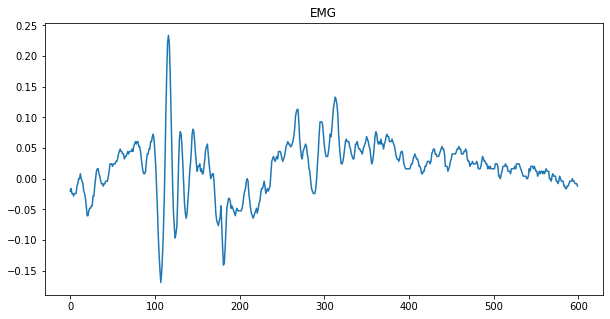

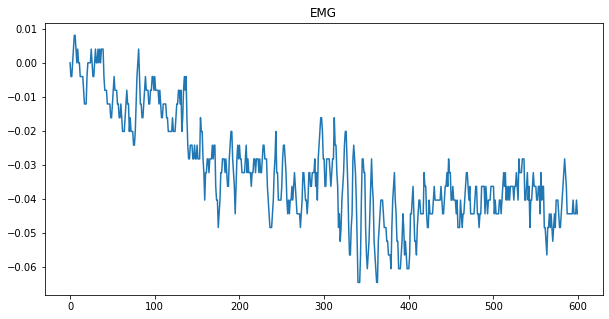

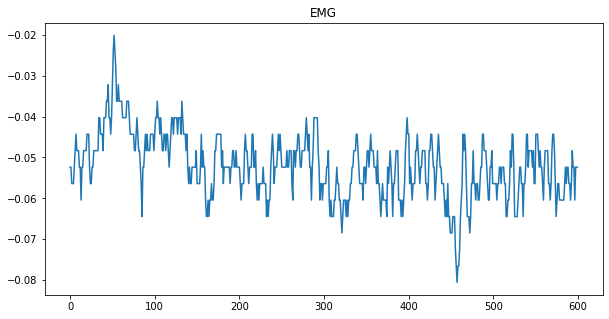

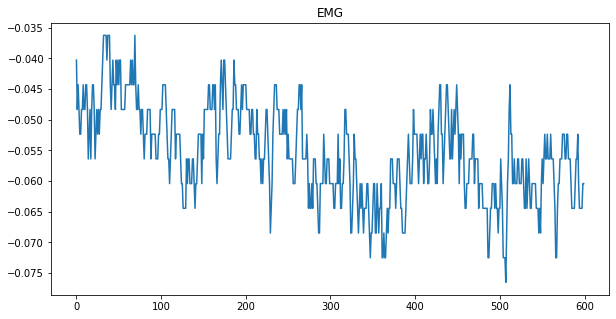

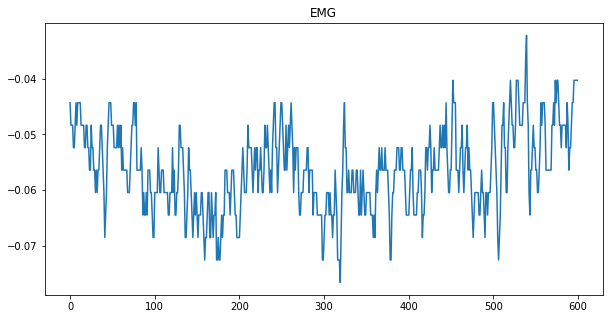

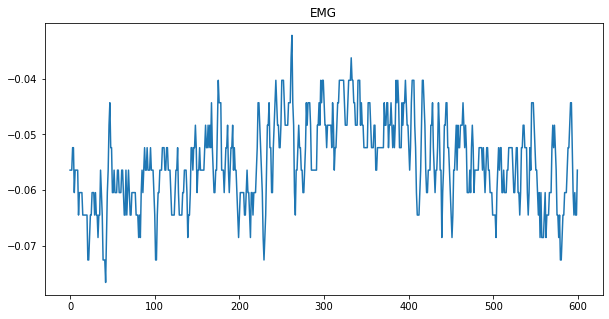

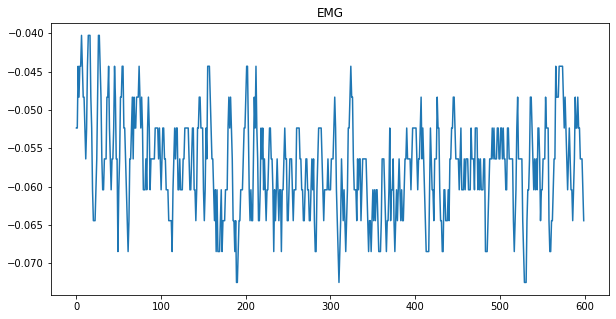

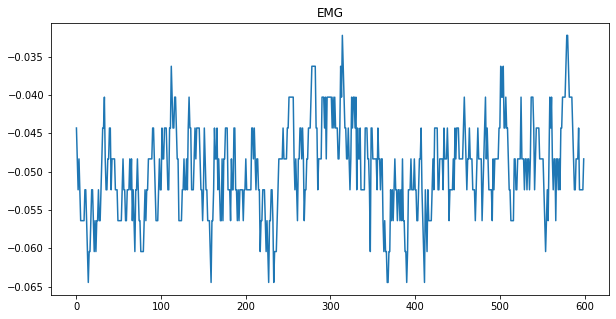

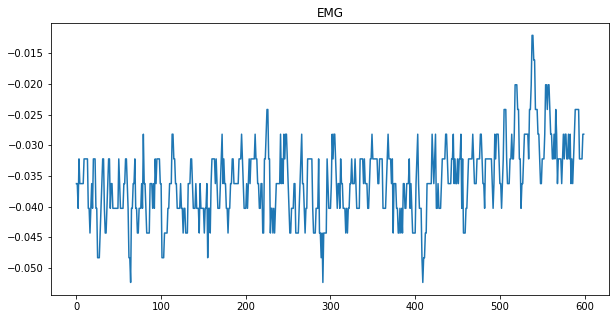

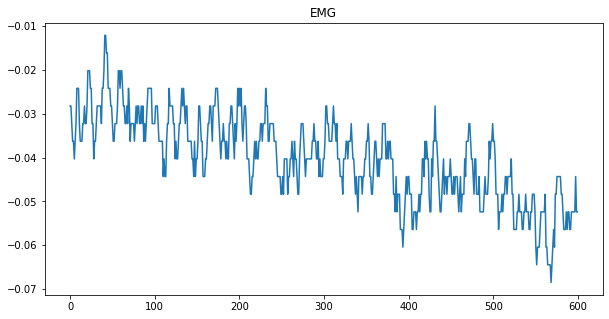

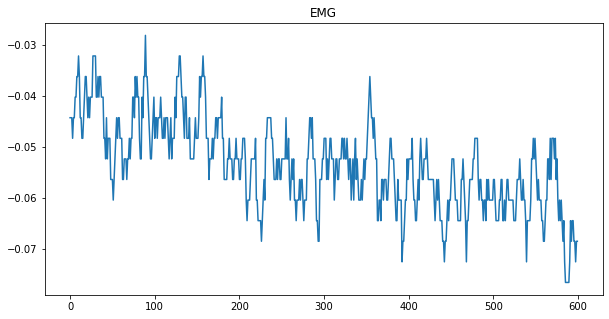

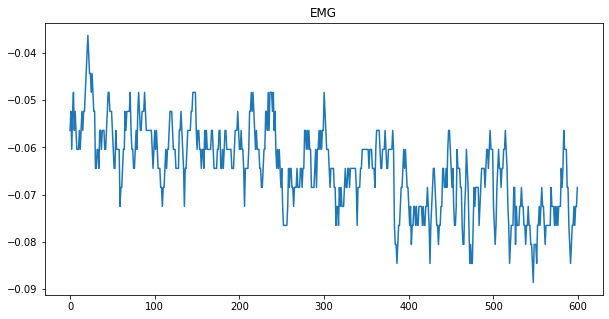

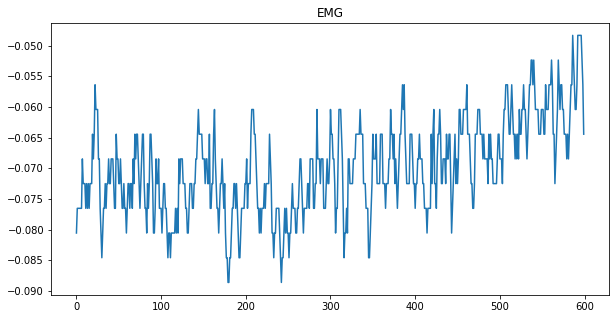

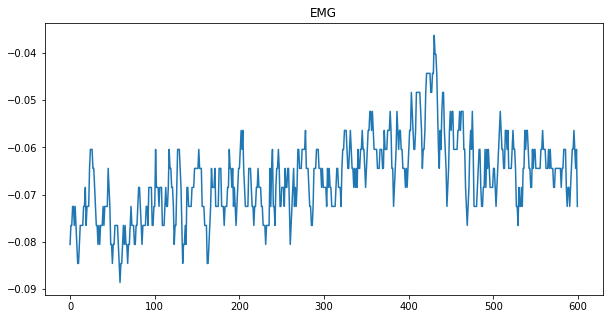

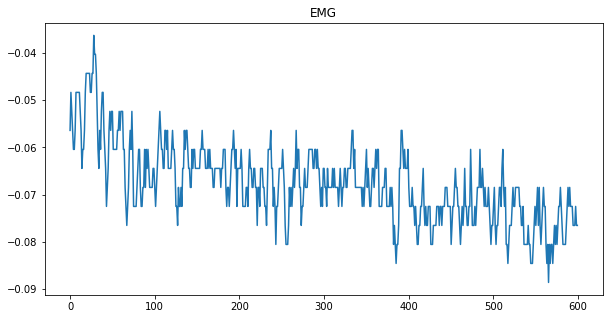

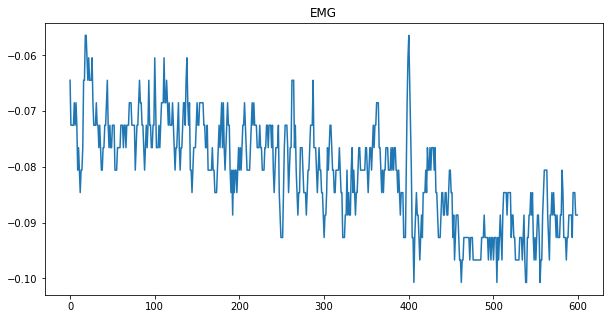

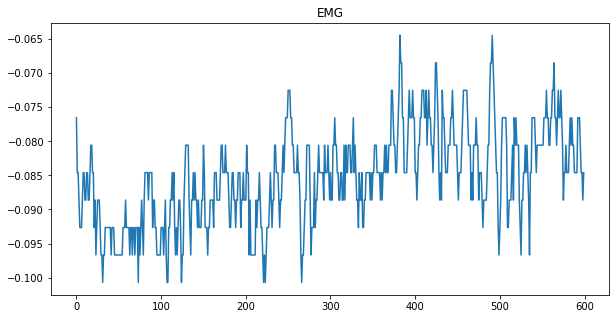

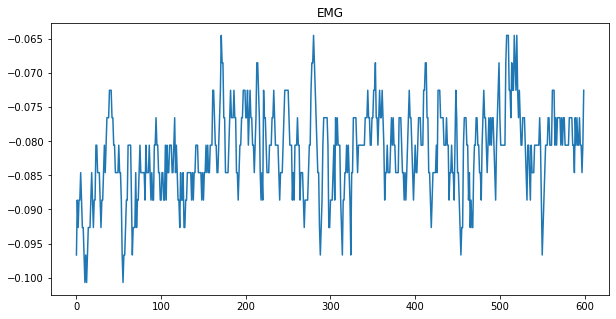

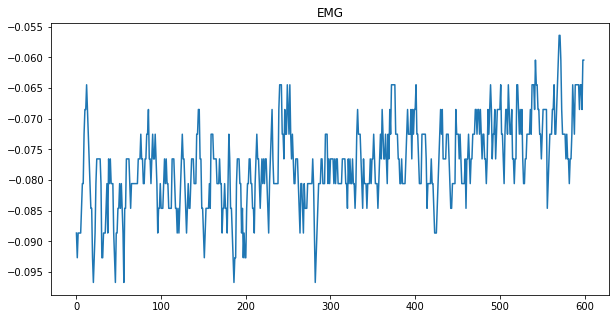

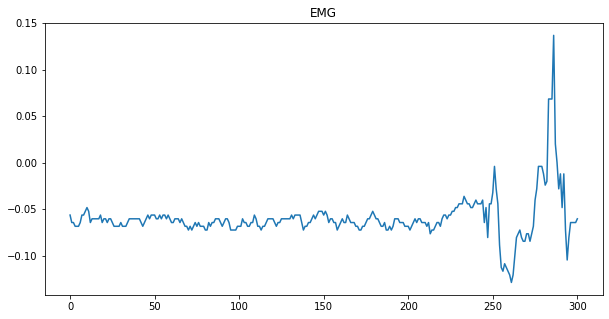

In [115]:
#Plot do EEG original 2 seg antes e 2 seg depois da colisão

#plt.plot(P1_T1_EMG_FCRX[idx_tempo_aprox[0] - 1024 : idx_tempo_aprox[0] + 1024])

for i in idx_tempo_aprox:
  plt.figure(figsize=[10, 5])
  plt.plot(emg_sinc[i - 300 : i + 300])
  plt.title("EMG")


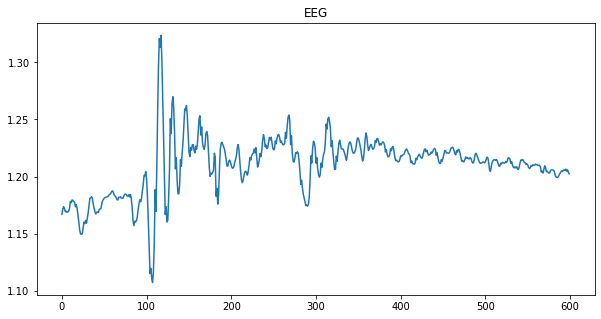

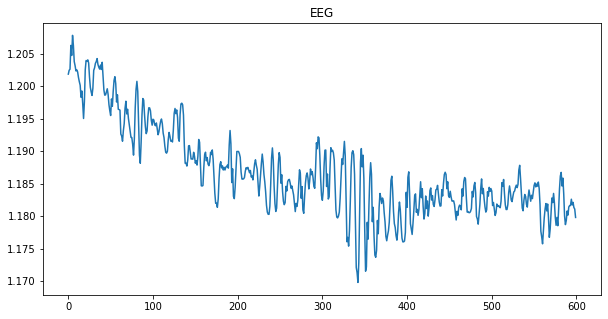

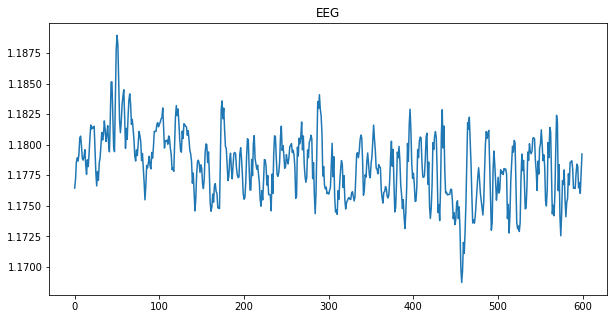

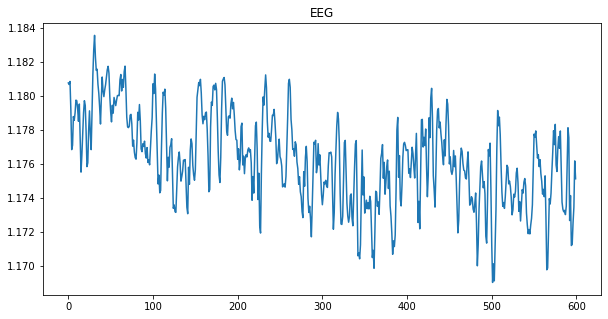

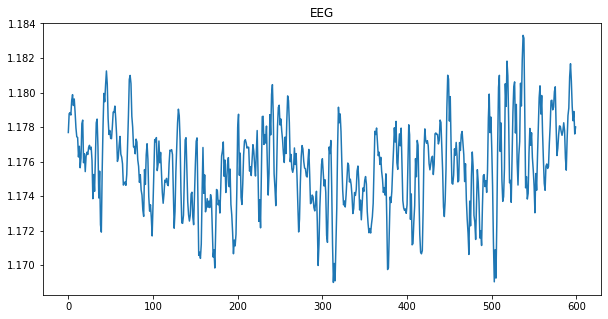

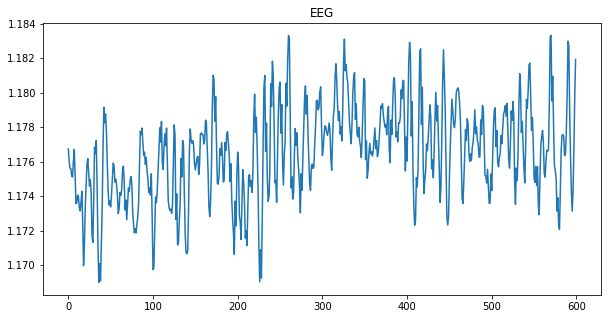

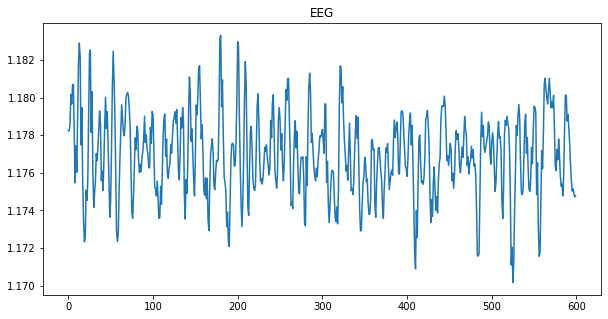

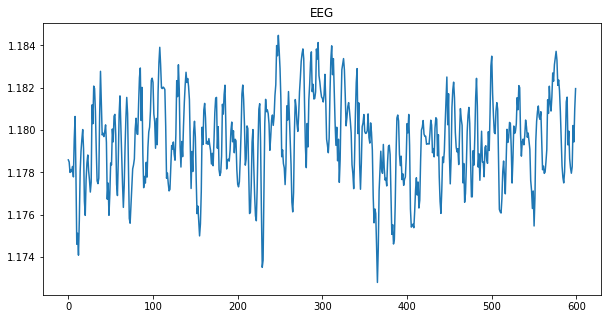

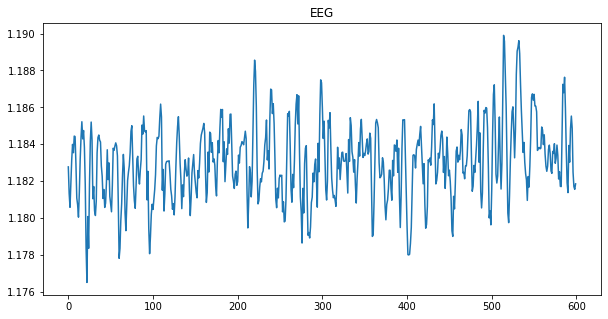

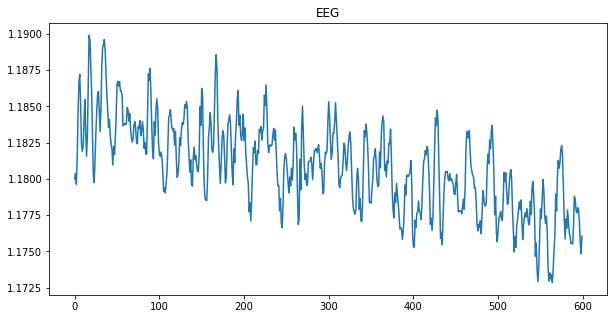

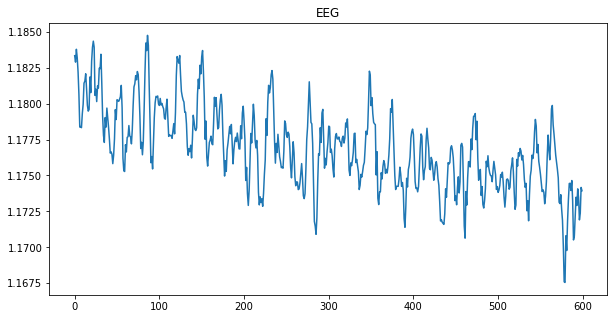

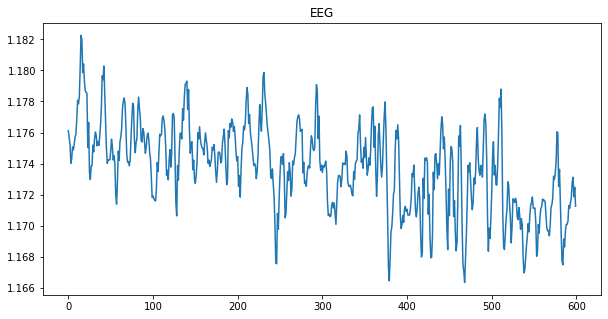

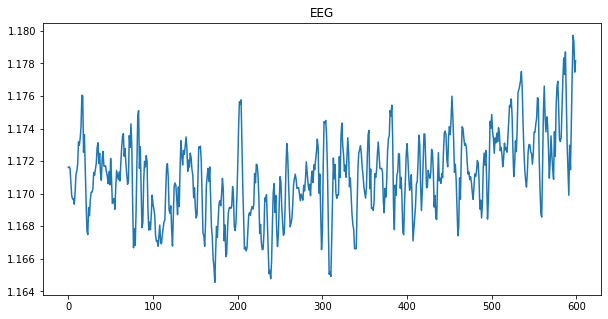

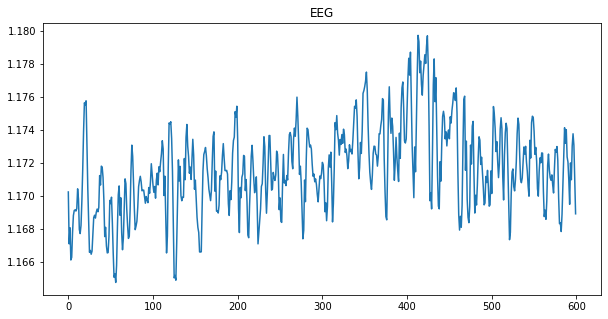

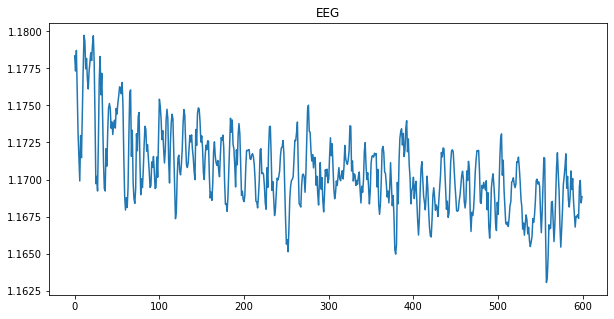

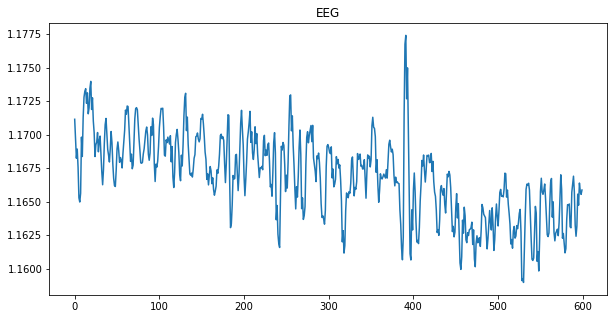

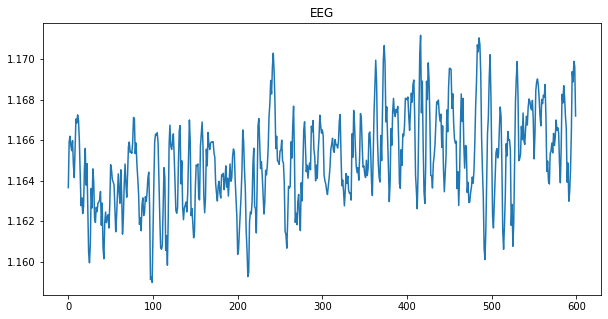

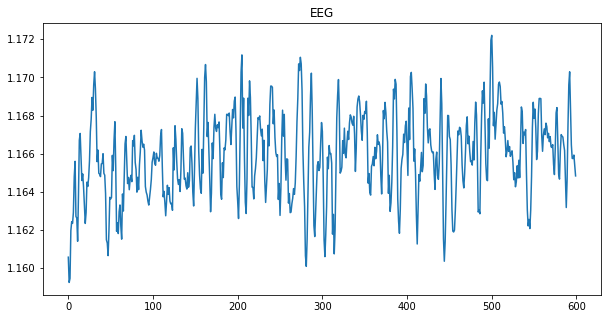

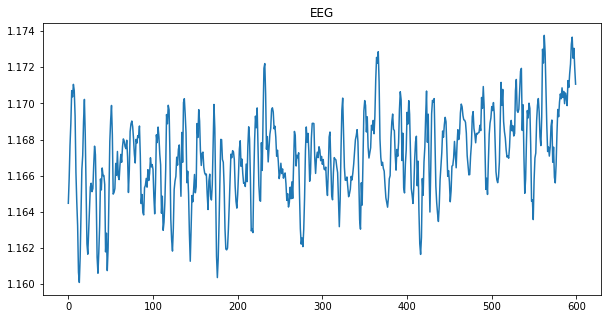

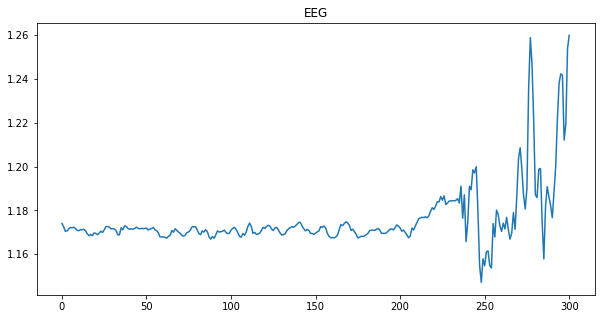

In [116]:
#plot de todas as colisões com o eeg sincronizado
#plt.plot(eeg_sinc[idx_tempo_aprox[2] - 512: idx_tempo_aprox[2]  + 512])
for i in idx_tempo_aprox:
  plt.figure(figsize=[10, 5])
  plt.plot(eeg_sinc[i - 300 : i + 300])
  plt.title("EEG")


In [118]:
colisoes=[]
for j in range(16):
  canal=[]
  for i in idx_tempo_aprox:
    antes = canais_sinc[j][i-300 : i]
    depois = canais_sinc[j][i : i+300]
    canal.append([antes, depois])
  colisoes.append(canal)

In [120]:
def Cortarcolisao(dados, idx_tempo_aprox):
  index_to_remove=[]
  for i in range(0,len(idx_tempo_aprox)-1):
    index_to_remove= index_to_remove + list(range(idx_tempo_aprox[i] + 300, idx_tempo_aprox[i+1]-300))
  #print(index_to_remove)

  new_dados = np.delete(dados, index_to_remove)
  return new_dados

In [121]:
emg_sinc= P1_T1_EMG_FCRX[0:10431].to_numpy()
#len(emglist)


In [122]:
rt_sinc_col = Cortarcolisao(rt_sinc, idx_tempo_aprox)
eeg_sinc_col = Cortarcolisao(eeg_sinc, idx_tempo_aprox)
emg_sinc_col = Cortarcolisao(emg_sinc, idx_tempo_aprox)

In [123]:
df = pd.DataFrame({'tempo': rt_sinc_col,
                   'EEG': eeg_sinc_col,
                   'EMG': emg_sinc_col
                   })

df.to_csv('/gdrive/My Drive/out.csv')
